In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
def julia(R, eps, bound = 4, z0 = -1-1j, z1 = 1+1j, niter = 20, halo = False):

    X = np.arange(np.real(z0), np.real(z1), eps)
    Y = np.arange(np.imag(z0), np.imag(z1), eps)

    C = []

    for x in X:
        C.append([])
        for y in Y:

            flag = 0;
            z0 = x+y*1j
            for i in range(niter):
                z0 = R(z0)
                if(np.abs(z0)>bound):
                    flag = halo*i+1;
                    break
            C[-1].append(flag)
    return np.array(C)

def convolve(C, kernel = np.array([[0,1,0], [1, 4, 1], [0, 1, 0]])):

    dict = {
        "blur":np.array([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]]),
        "sharpen":np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]),
        "left_edge":np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]]),
        "right_edge":-np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    }

    if(type(kernel)==str):
        kernel = dict[kernel]

    w = len(C[0])
    h = len(C)

    step = len(kernel)//2
    new = np.ndarray.tolist(C[:step])

    for i in range(step, h-step):
        new.append(np.ndarray.tolist(C[i][:step]))
        for j in range(step, w-step):
            new[-1].append(sum(sum(C[i-step:i+step+1][:,j-step:j+step+1] * kernel)))
        new[-1].extend(C[i][-step:])
    
    new.extend(np.ndarray.tolist(C[-step:]))
    return np.array(new)

In [41]:
def R(z): #0.35-0.5 pretty, 
    return (z**2-1+0j)

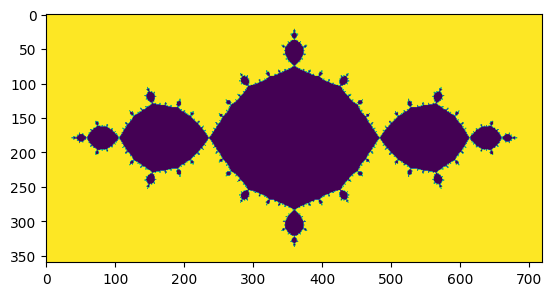

In [143]:
z0 = -1.8-0.9j;
z1 = 1.8+0.9j;
eps = 0.005;

C = julia(R, eps, bound = 2, z0 = z0, z1 = z1, niter = 30, halo = False)
plt.imshow(C.T)

### Detecting Blobs

In [144]:
def findEdge(C): #characterizes the edges (in such a way that they form a connected set)
    edgeCoords = []

    for i in range(1, len(C)-1):
        for j in range(1, len(C[0])-1):
            if not (C[i-1:i+1+1][:,j-1:j+1+1].reshape(9)==C[i][j]).all():
                edgeCoords.append((i,j))
    return edgeCoords

def createEdge(C):
    coords = findEdge(C);
    a = np.ones(C.shape)
    for coord in coords:
        a[coord[0]][coord[1]] = 0;
    return a


def points(D): #gets one point from each blob

    sys.setrecursionlimit(1000000) #since this recurses a bunch of times apparently for some reason

    pointArr = []

    checked = np.zeros((len(D), len(D[0])))
    for i in range(len(checked)):
        checked[i][0] = 1;
        checked[i][-1]=1;
    for i in range(len(checked[0])):
        checked[0][i] = 1;
        checked[-1][i] = 1;

    for i in range(1, len(D)-1):
        for j in range(1, len(D[0])-1):
            if not D[i][j] and not checked[i][j]:
                pointArr.append((i,j))
                expand(D, (i,j), checked)
    return pointArr

def expand(D, point, checked): #helper function for points

    x = point[0]
    y = point[1]

    checked[x][y] = True

    for i in range(x-1, x+2):
        for j in range(y-1, y+2):
            if not D[i][j] and not checked[i][j]:
                expand(D, (i,j), checked)
    return

In [145]:
def characterize_blobs(D): #gets the edge array and returns new array where each blob consists of a different number
    
    arr = -np.ones(D.shape); #border of image
    arr[0], arr[:,0], arr[-1], arr[:,-1] = 0, 0, 0, 0;

    color = 1;
    for i in range(1, len(D)-1):
        for j in range(1, len(D[0])-1):
            
            if(arr[i][j]<0 and D[i][j]):
                expand(i, j, color, D, arr);
                color+=1;

    return arr

def expand(i, j, color, D, arr):

    arr[i][j] = color;
    for i1 in range(i-1, i+2):
        for j1 in range(j-1, j+2):
            if D[i1][j1] and arr[i1][j1]<0:
                expand(i1, j1, color, D, arr);
    return

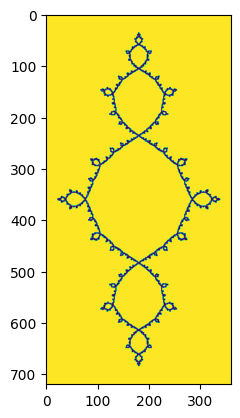

In [146]:
D = createEdge(C)
plt.imshow(D)

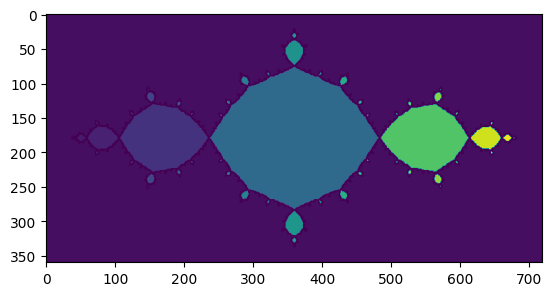

In [150]:
b = characterize_blobs(D)
plt.imshow(b.T)

In [168]:
def coordToIndex(xarr, yarr, x, y):
    eps1 = xarr[1]-xarr[0];
    eps2 = yarr[1]-yarr[0];

    return (int((x-xarr[0])/eps1), int((y-yarr[0])/eps2))

def indexToCoord(xarr, yarr, i, j):
    return (xarr[i], yarr[j])

In [169]:
#now assume we want to see when a point p falls into a given fatou cycle. we will start the easy way,
#so we will assume to we know what fatou cycle points fall into ahead of time.

In [176]:
f0 = b[len(b)//2][len(b[0])//2]
f1 = b[550][200]

In [177]:
f0score = 0;
f1score = 0;

niter = 10;

X = np.arange(np.real(z0), np.real(z1), eps)
Y = np.arange(np.imag(z0), np.imag(z1), eps)

for x in X:
    for y in Y:

        i, j = coordToIndex(X, Y, x, y);
        if(b[i][j] != f0 and b[i][j] != f1):
            z = x+y*1j;

            for rep in range(niter):
                z = R(z);
                i, j = coordToIndex(X, Y, z.real, z.imag);
                if(i>=len(b) or j>=len(b[0]) or i<0 or j<0):
                    continue;

                if b[i][j] == f0:
                    f0score += 1;
                    break
                elif b[i][j] == f1:
                    f1score += 1;
                    break

In [178]:
f0score

10123

In [179]:
f1score

6155